In [1]:
# Import libraries
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix

In [2]:
def add_poly_terms(feat, n_feats=None, max_pot=5):
    # This function add polynomial terms up to max_pot power to the first n_feats
    # variables to the features' matrix up to the max_pot power
    n_samples = feat.shape[0]
    if n_feats is None:
        n_feats = feat.shape[1]
    feat_list = [feat]
    for pot in range(2, max_pot+1):
        feat_list +=  [np.reshape(feat[:,i]**pot, (n_samples,1)) for i in range(n_feats)]
    return np.concatenate(feat_list, axis=1)

def add_iter_terms(feat, n_feats=None):
    # This function add iteration terms of the first n_feats
    # variables to the features' matrix
    n_samples = feat.shape[0]
    if n_feats is None:
        n_feats = feat.shape[1]
    feat_list = [feat]
    for i in range(n_feats):
        for j in range(i+1,n_feats):
            feat_list += [np.reshape(feat[:,i]*feat[:,j], (n_samples,1))]
    return np.concatenate(feat_list, axis=1)

def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    """
    import itertools

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def print_rates(cm, classes):
    success_rate = []
    for i in range(len(cm)):
        success_rate.append(cm[i][i] / np.sum(cm[i]))
    
    x_pos = np.arange(len(classes))
    
    fig, ax = plt.subplots()    
    plt.bar(x_pos, success_rate)
    plt.xticks(x_pos, classes, rotation=45)
    ax.yaxis.set_visible(False)
    ax.axis([-1, 6, 0, 1.1])
    plt.title('Success rate for each class')
    #plt.ylabel('Success rate')
    for i, v in enumerate(success_rate):
        ax.text(i, v+0.01, format(success_rate[i], '.2f'),
                horizontalalignment="center",
                color='black', fontweight='bold')    
    plt.show()
    
# Eliminate NaN entries
def remove_nan(X):
    col_mean = np.nanmean(X, axis=0)
    inds = np.where(np.isnan(X))
    X[inds] = np.take(col_mean, inds[1])
    
def normalize_data(X):
    from sklearn.preprocessing import StandardScaler
    sc_X = StandardScaler()
    return sc_X.fit_transform(X)

In [3]:
# read the data set
data_set = pd.read_csv('WISDM_ar_v1.1_transformed.csv')
X = data_set.iloc[:, 2:-1].values # eliminate not important colums 
y = data_set.iloc[:,-1].values

In [4]:
# Eliminate NaN entries
col_mean = np.nanmean(X, axis=0)
inds = np.where(np.isnan(X))
X[inds] = np.take(col_mean, inds[1])

In [5]:
# Feature scaling
sc_X = StandardScaler()
X = sc_X.fit_transform(X)

In [6]:
# Split the dataset into the Training set and the Test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=0)

In [7]:
# 10-fold CV to assess SVM model with radial kernel
clf = svm.SVC(kernel='rbf', random_state=0, class_weight='balanced')
scores = cross_val_score(clf, X_train, y_train, cv=10)
print('SVM score on training set with radial kernel (10-fold CV): %f' % scores.mean())

SVM score on training set with radial kernel (10-fold CV): 0.763129


In [8]:
# Predicting classes on test set and evaluate accuracy 
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print('SVM score on test set with radial kernel: %f' % (np.mean(y_pred == y_test)))

SVM score on test set with radial kernel: 0.763838


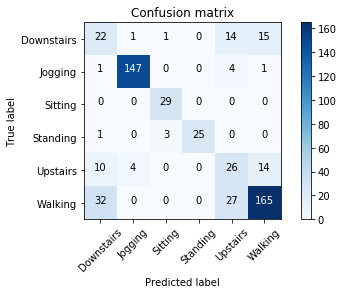

In [9]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
classes = np.unique(y_train)
plot_confusion_matrix(cm, classes=classes, title='Confusion matrix')

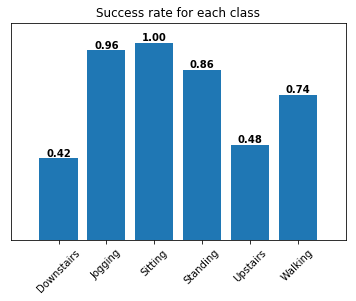

In [10]:
print_rates(cm, classes)

SVM score on test set with linear kernel: 0.743542


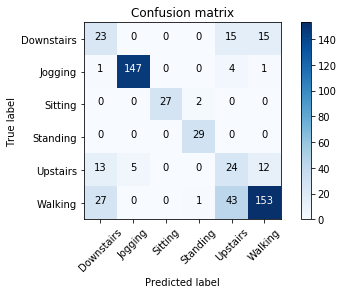

In [18]:
from sklearn.multiclass import OneVsOneClassifier
# Here I change from "one-vs-all" approch to "one-vs-one"
# this could give better results when two or more classes are very similar
# like "Downstairs" and "Upstairs" in our case
svm_lin = OneVsOneClassifier(svm.SVC(kernel='linear', class_weight='balanced'))

svm_lin.fit(X_train, y_train)
y_predict_lin = svm_lin.predict(X_test)

print('SVM score on test set with linear kernel: %f' % (np.mean(y_predict_lin == y_test)))

cm_lin = confusion_matrix(y_test, y_predict_lin)
plot_confusion_matrix(cm_lin, classes=classes, title='Confusion matrix')

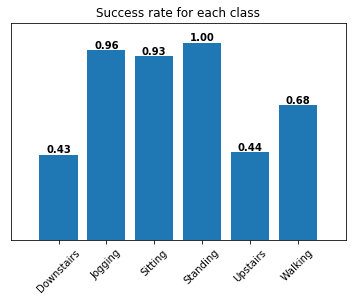

In [19]:
print_rates(cm_lin, classes)

SVM score on test set with polynomial kernel (d=3): 0.743542


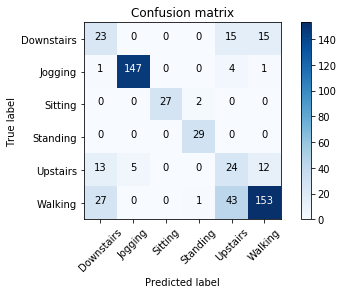

In [16]:
# Here I assess SVM with polynomial kernel with d=3
svm_poly = svm.SVC(kernel='poly', class_weight='balanced', degree=3)

svm_poly.fit(X_train, y_train)
y_predict_poly = svm_poly.predict(X_test)

print('SVM score on test set with polynomial kernel (d=3): %f' % (np.mean(y_predict_lin == y_test)))

cm_poly = confusion_matrix(y_test, y_predict_lin)
plot_confusion_matrix(cm_poly, classes=classes, title='Confusion matrix')

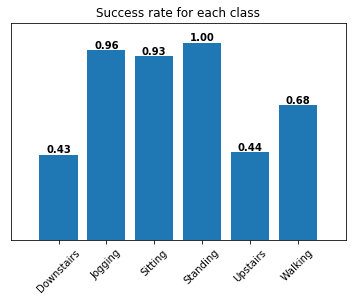

In [17]:
print_rates(cm_poly, classes)

# Overall the results were pretty much the same for all kernels (radial, polynomial and linear)
# with a little advantage for the radial kernel (76% against 74%)